# Yawed rotor wakes

This example demonstrates wake modelling for yawed wind turbine rotors, following [Bastankhah & Porte-Agel](https://doi.org/10.1017/jfm.2016.595). Let's start by importing the required packages:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import foxes
import foxes.variables as FV

Our aim in this example is to model two turbines that are located along the x axis, and uniform wind from west. Three states should be computed, with identical wind conditions, in a setup where the first turbine is yawed by 30, 0, -30 degrees, respectively.

We can realize these wind conditions with the `StatesTable` class, using a `pandas.DataFrame` object as data as source:

In [2]:
sdata = pd.DataFrame(index=range(3))
sdata[FV.WS] = 8.0
sdata[FV.WD] = 270.0
sdata

,WS,WD
0,8.0,270.0
1,8.0,270.0
2,8.0,270.0


In [3]:
states = foxes.input.states.StatesTable(
    data_source=sdata,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

For each of these 3 states, and for each of the two turbines, we wish to set the yaw misalignment variable `FV.YAWM`. The following `numpy.ndarray` defines these angles, with shape `(3, 2)` representing `(FC.STATE, FC.TURBINE)` dimensions:

In [4]:
yawm = np.array([[30.0, 0.0], [0.0, 0.0], [-30.0, 0.0]])
yawm

array([[ 30.,   0.],
       [  0.,   0.],
       [-30.,   0.]])

For transferring these data to the variable `FV.YAWM`, we invoke the turbine model `SetFarmVars`, by adding it to the `turbine_models` section of the `ModelBook`:

In [5]:
mbook = foxes.ModelBook()
mbook.turbine_models["set_yawm"] = foxes.models.turbine_models.SetFarmVars()
mbook.turbine_models["set_yawm"].add_var(FV.YAWM, yawm)

Notice that this models appears together with the model `yawm2yaw`, which exists by default in the `ModelBook`:

In [6]:
farm = foxes.WindFarm()
farm.add_turbine(
    foxes.Turbine(
        xy=[0.0, 0.0],
        turbine_models=["set_yawm", "yawm2yaw", "NREL5MW", "kTI_05"],
    )
)
farm.add_turbine(
    foxes.Turbine(
        xy=[1000.0, 0.0],
        turbine_models=["set_yawm", "yawm2yaw", "NREL5MW", "kTI_05"],
    )
)

Turbine 0, T0: xy=(0.00, 0.00), set_yawm, yawm2yaw, NREL5MW, kTI_05
Turbine 1, T1: xy=(1000.00, 0.00), set_yawm, yawm2yaw, NREL5MW, kTI_05


The `yawm2yaw` updates the `FV.YAW` variable by adding `FV.YAWM` to the wind direction, i.e., the yaw misalignment defines the absolute rotor yaw in this case (in cases where the latter is set, you may want to include the inverse model `yaw2yawm` instead).

We can now create an `Algorithm` object and calculate the farm results. We combine the `TurbOPark` model with the classic wake deflection model by [Jimenez et al.](https://onlinelibrary.wiley.com/doi/epdf/10.1002/we.380). Note that the usage of this model requires a wind vector superposition model, since it induces a wind vector rotation within the wake:

In [7]:
algo = foxes.algorithms.Downwind(
    farm,
    states,
    rotor_model="centre",
    wake_models=["TurbOPark_vector_ambka004", "CrespoHernandez_quadratic"],
    wake_deflection="Jimenez",
    mbook=mbook,
    verbosity=0,
)

In [8]:
farm_results = algo.calc_farm()

Selecting 'DefaultEngine(n_procs=16, chunk_size_states=None, chunk_size_points=None)'
DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating 3 states for 2 turbines
SingleChunkEngine: Running single chunk calculation for 3 states


Once the wind farm results are ready we can continue and plot the wind field:

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating data at 31411 points for 3 states


ProcessEngine: Computing 48 chunks using 16 processes


  0%|                                                                                            | 0/48 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1153.51it/s]

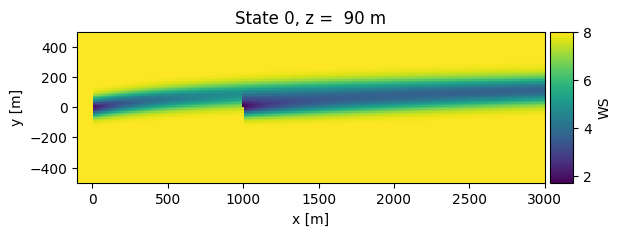

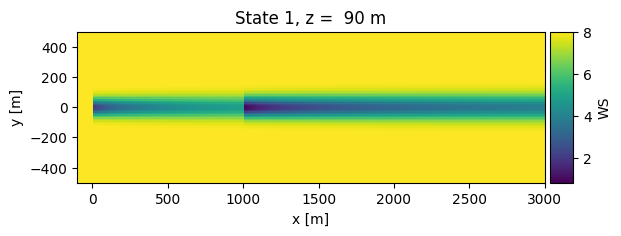

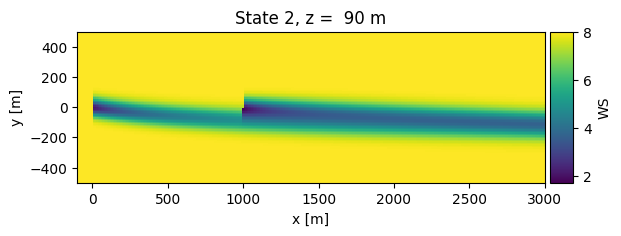

In [9]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(FV.WS, resolution=10, xmin=-100, xmax=3000, verbosity=0)
for fig in g:
    plt.show()

As well as some vertical cross sections some distance downstream:

DefaultEngine: Selecting engine 'single'
SingleChunkEngine: Calculating data at 1066 points for 3 states
SingleChunkEngine: Running single chunk calculation for 3 states


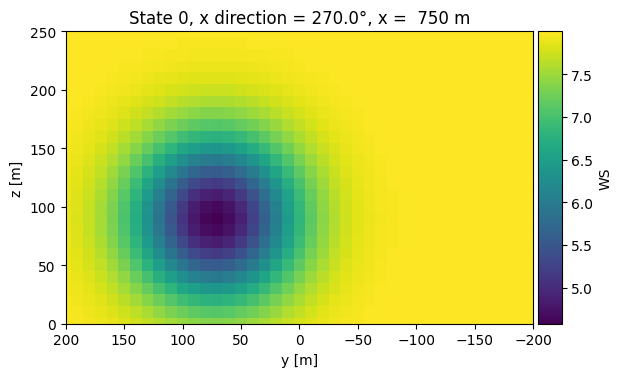

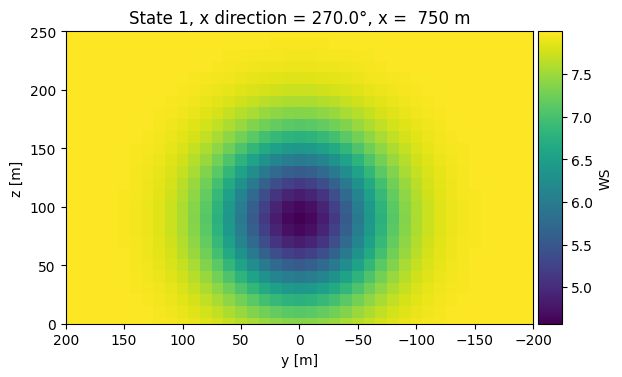

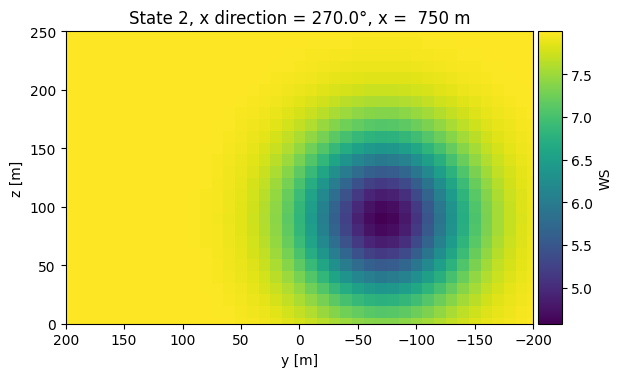

In [10]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_yz(
    FV.WS, resolution=10, x=750, ymin=-200, ymax=200, zmin=0, zmax=250, verbosity=0
)
for fig in g:
    plt.show()

Clearly, the model bends the wake and a frontal hit of the downstream rotor is avoided under yawed conditions. This also reflects in the rotor equivalent wind speed (REWS) values:

In [11]:
farm_df = farm_results.to_dataframe()
print("\nFarm results:\n")
print(farm_df[[FV.X, FV.WD, FV.YAW, FV.YAWM, FV.REWS]])


Farm results:

                    X          WD         YAW  YAWM      REWS
state turbine                                                
0     0           0.0  270.000000  300.000000  30.0  8.000000
      1        1000.0  267.310067  267.310067   0.0  7.153025
1     0           0.0  270.000000  270.000000   0.0  8.000000
      1        1000.0  270.000000  270.000000   0.0  5.783960
2     0           0.0  270.000000  240.000000 -30.0  8.000000
      1        1000.0  272.689933  272.689933   0.0  7.153025


The `Jimenez` model also generates a change of the wind direction along the wake path, i.e., a rotation of the wind vector:

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating data at 31411 points for 3 states


ProcessEngine: Computing 48 chunks using 16 processes


  0%|                                                                                            | 0/48 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1079.39it/s]

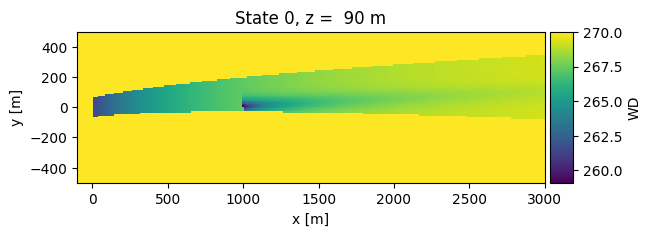

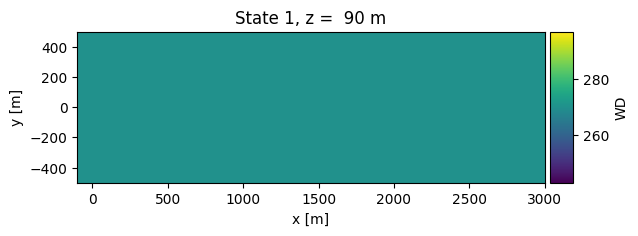

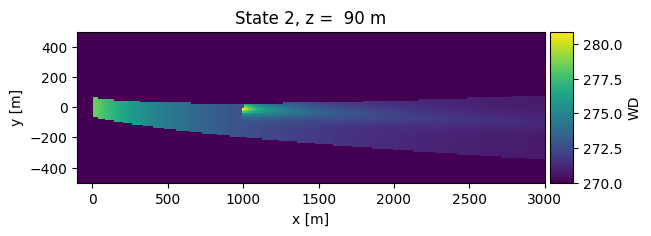

In [12]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(FV.WD, resolution=10, xmin=-100, xmax=3000, verbosity=0)
for fig in g:
    plt.show()

Other wake deflection models, like `JimenezProj`, `JimenezPath` or `Bastankhah2016` do not affect the wind direction variable.

By default, the turbine type models in `foxes` apply $\cos(\gamma)^p$ type yaw corection factors to the variables `FV.P` and `FV.CT`, where `\gamma` is the yaw misalignment angle (i.e., `FV.YAWM` translated to radiants), and `p` is a constant exponent (in fact there is one for power and another for thrust). These exponents can be setup as desired, here the default values $p_P = 1.88$ and $p_{ct}=1.0$ were invoked.

Note that the `yawed` wake frame can bend any kind of wake model. For example, we invoked the `CrespoHernandez` model for turbulence intensity wake effects above. This wake model follows the same bending rules as the wind deficit model, even though it is a simple top-hat type model:

DefaultEngine: Selecting engine 'process'
ProcessEngine: Calculating data at 31411 points for 3 states


ProcessEngine: Computing 48 chunks using 16 processes


  0%|                                                                                            | 0/48 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1130.98it/s]

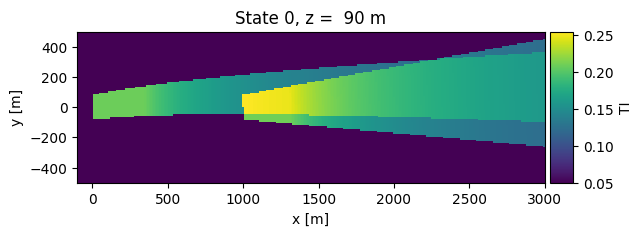

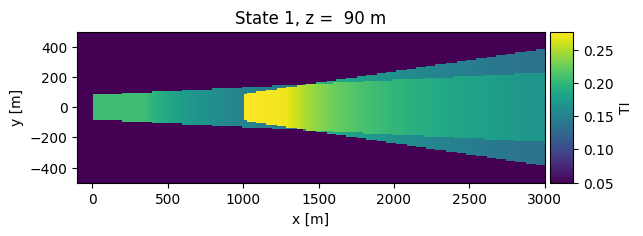

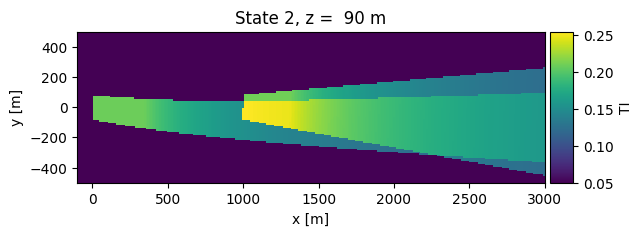

In [13]:
o = foxes.output.FlowPlots2D(algo, farm_results)
g = o.gen_states_fig_xy(FV.TI, resolution=10, xmin=-100, xmax=3000, verbosity=0)
for fig in g:
    plt.show()